# Speech recognition using RNN

In [1]:
from os import listdir
from os.path import isdir, join
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features
from scipy.io import wavfile

### Load features

In [2]:
feature_sets_file = 'mfcc_sets.npz'
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_test', 'y_test', 'words']

In [3]:
words = feature_sets['words']
print(words)

['yes' 'no' 'up' 'down' 'left' 'right' 'on' 'off' 'stop' 'go' 'forward'
 'backward']


In [4]:
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(25450, 20, 99)
(25450,)
(12536, 20, 99)
(12536,)


In [5]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

In [6]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
#x_val = x_val.reshape(x_val.shape[0], 
                      #x_val.shape[1], 
                      #x_val.shape[2], 
                      #1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
#print(x_val.shape)
print(x_test.shape)

(25450, 20, 99, 1)
(12536, 20, 99, 1)


In [7]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(20, 99, 1)


In [8]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(words), activation='sigmoid'))
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 19, 98, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 49, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 48, 32)         4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 24, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 23, 64)         8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 11, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 704)               0

In [9]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
EPOCHS = 30
history = model.fit(
    x_train, 
    y_train,  
    epochs=EPOCHS,
    batch_size=100
)

Epoch 1/30
255/255 [==============================] - 14s 57ms/step - loss: 2.3519 - accuracy: 0.1615
Epoch 2/30
255/255 [==============================] - 15s 58ms/step - loss: 1.8751 - accuracy: 0.3219
Epoch 3/30
255/255 [==============================] - 16s 62ms/step - loss: 1.5697 - accuracy: 0.4490
Epoch 4/30
255/255 [==============================] - 16s 63ms/step - loss: 1.2968 - accuracy: 0.5536
Epoch 5/30
255/255 [==============================] - 19s 73ms/step - loss: 1.1289 - accuracy: 0.6114
Epoch 6/30
255/255 [==============================] - 19s 74ms/step - loss: 0.9788 - accuracy: 0.6683
Epoch 7/30
255/255 [==============================] - 19s 75ms/step - loss: 0.9059 - accuracy: 0.6918
Epoch 8/30
255/255 [==============================] - 19s 74ms/step - loss: 0.8240 - accuracy: 0.7195
Epoch 9/30
255/255 [==============================] - 19s 74ms/step - loss: 0.7677 - accuracy: 0.7374
Epoch 10/30
255/255 [==============================] - 19s 73ms/step - loss: 0.707

In [11]:
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = y_test

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 89%


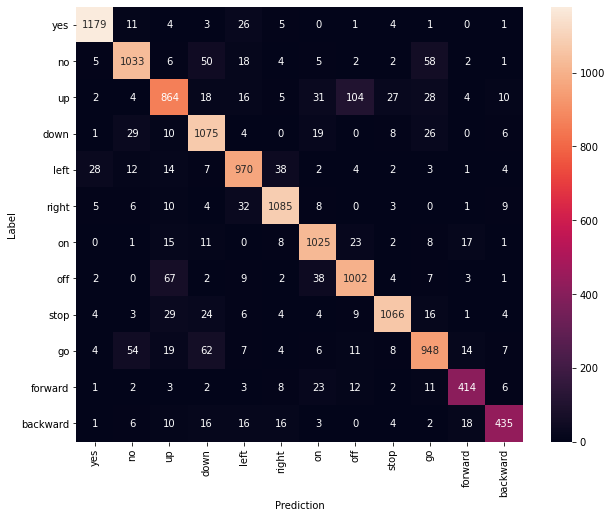

In [12]:
import seaborn as sns
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=words, yticklabels=words, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()